In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from os import listdir
from os.path import isfile, join
from scipy import stats
from skimage import io

import sys
sys.path.append('..')
import src as tools

COLOR_MAP = {
    "light_orange": "#E69F00",
    "light_blue": "#56B4E9",
    "teal": "#009E73",
    "yellow": "#F0E442",
    "dark_blue": "#0072B2",
    "dark_orange": "#D55E00",
    "pink": "#CC79A7",
    "purple": "#9370DB",
    "black": "#000000",
    "silver": "#DCDCDC",
}

# 1. Load Data

Load 2019 and 2020 data.

In [2]:
df_2019 = pd.read_csv(f"{tools.PROJECT_FOLDER}/data/2022_10_05_parsed_2019_encoded.csv", index_col = 0)
df_2020 = pd.read_csv(f"{tools.PROJECT_FOLDER}/data/2022_10_05_parsed_2020_encoded.csv", index_col = 0)

df = pd.concat([df_2019, df_2020])
df.reset_index(drop = True, inplace = True)

for col in df.columns:
    if "date" in col:
        df[col] = pd.to_datetime(df[col])

print(f"{df.shape[0]} entries remaining.")
df.tail()

22537 entries remaining.


,date,change_idx,log_num,pdf_page,call_datetime,call_reason,call_type,call_action,call_taker,street,call_category,responding_units,disp_datetime,clrd_datetime
22532,2020-10-24,337190,20-9090b,1472,2020-10-24 01:38:00,B.O.L.O.,Phone,PATROL ADVISED,7.0,133.0,Nonemergency Service,4.0,2020-10-24 01:41:22,2020-10-24 01:50:02
22533,2020-10-24,337190,20-9090c,1472,2020-10-24 01:38:00,B.O.L.O.,Phone,PATROL ADVISED,7.0,133.0,Nonemergency Service,9.0,2020-10-24 01:41:28,2020-10-24 01:50:08
22534,2020-10-24,337286,20-9091,1472,2020-10-24 02:56:00,PARKING CHECK,Initiated,SERVICES RENDERED,16.0,133.0,Initiated,2.0,2020-10-24 02:56:00,2020-10-24 02:57:31
22535,2020-10-24,337308,20-9092,1472,2020-10-24 08:35:00,BUILDING CHECK,Initiated,BUILDING CHECKED/SECURED,14.0,105.0,Initiated,6.0,2020-10-24 08:35:00,2020-10-24 08:36:37
22536,2020-10-24,337338,20-9093,1472,2020-10-24 08:39:00,BUILDING CHECK,Initiated,BUILDING CHECKED/SECURED,14.0,48.0,Initiated,NaN,2020-10-24 08:39:00,NaT


In [3]:
df_log_count = pd.DataFrame(columns = [2019,2020])

# Total log count from Williamstown Annual Report.
total_log_count_2019 = 15973
total_log_count_2020 = 10921
df_log_count.loc["total_log_count"] = [total_log_count_2019,total_log_count_2020]

# Adjusted log count from records request.
foia_log_count_2019 = 15973
foia_log_count_2020 = int(10921 - (2*(10921/12)))
df_log_count.loc["foia_log_count"] = [foia_log_count_2019,foia_log_count_2020]

# Logs accounted for after OCR step.
ocr_log_count_2019 = df_2019.drop_duplicates("change_idx").shape[0]
ocr_log_count_2020 = df_2020.drop_duplicates("change_idx").shape[0]
df_log_count.loc["ocr_log_count"] = [ocr_log_count_2019,ocr_log_count_2020]

# Logs accounted for after dropping dates after Covid lockdown.
covid = pd.to_datetime("2020-03-10")
df_pre_covid_count = df[(df["date"] >= pd.to_datetime("2020-01-01"))&(df["date"] < covid)].drop_duplicates("change_idx").shape[0]
df_2019_count = df_2019.drop_duplicates("change_idx").shape[0]
df_log_count.loc["pre_covid_log_count"] = [df_2019_count, df_pre_covid_count]

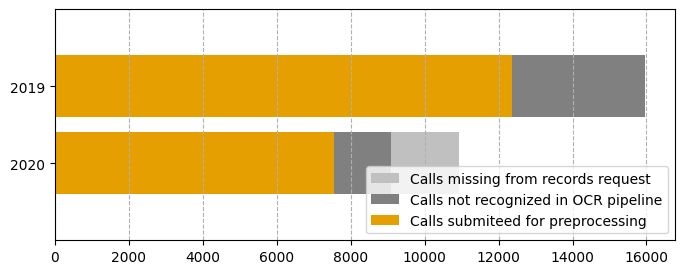

In [4]:
fig, ax = plt.subplots(figsize = (8,3))


width = df_log_count.loc["total_log_count"]
ax.barh(y = df_log_count.columns, 
        width = width, 
        label = "Calls missing from records request", 
        color = "silver",
        zorder = 1)

width = df_log_count.loc["foia_log_count"]
ax.barh(y = df_log_count.columns, 
        width = width, 
        label = "Calls not recognized in OCR pipeline", 
        color = "grey",
        zorder = 1)

width = df_log_count.loc["ocr_log_count"]
ax.barh(y = df_log_count.columns, 
        width = width, 
        label = "Calls submiteed for preprocessing",
        color = COLOR_MAP["light_orange"],
        zorder = 1)

ax.set_yticks([2019,2020])
ax.set_yticklabels([2019,2020])
ax.set_ylim(2021, 2018)
ax.xaxis.grid(True, linestyle = "--", zorder = 0)

plt.legend()
plt.show()

In [5]:
print("Percentage of expected calls not read by OCR for each calendar year:")
100 - np.around(100 * df_log_count.loc["ocr_log_count"]/df_log_count.loc["foia_log_count"], decimals = 1)

Percentage of expected calls not read by OCR for each calendar year:


2019    22.7
2020    17.2
dtype: float64

In [6]:
df_log_count

,2019,2020
total_log_count,15973,10921
foia_log_count,15973,9100
ocr_log_count,12355,7535
pre_covid_log_count,12355,2674


# 3. Preprocess Data

In the section we'll deal with incorrect and missing data.   Before we start we want to get a general overview of data quality.

In [7]:
print(f"{df.shape[0]} entries remaining.")
pre = df[df["date"] < covid].shape[0]
print(f"{pre} pre-covid entries remaining.")
print("")
print("Current Data Coverage: ")
df.count()/df.shape[0]*100

22537 entries remaining.
17187 pre-covid entries remaining.

Current Data Coverage: 


date                100.000000
change_idx          100.000000
log_num             100.000000
pdf_page            100.000000
call_datetime        92.115188
call_reason         100.000000
call_type           100.000000
call_action         100.000000
call_taker          100.000000
street              100.000000
call_category       100.000000
responding_units     84.154945
disp_datetime        93.064738
clrd_datetime        74.779252
dtype: float64

Let's double check that the dates are in the correct order.  In the plot below, we expect to see a line that rises roughly diagonally from the lower left to the upper right.

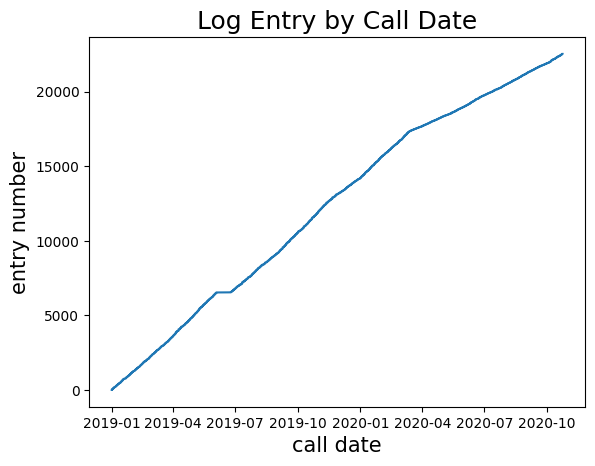

In [8]:
fig, ax = plt.subplots()
ax.plot(df["date"], df.index)
ax.set_xlabel("call date", fontsize = 15)
ax.set_ylabel("entry number", fontsize = 15)
ax.set_title("Log Entry by Call Date", fontsize = 18)
plt.show()

## Deal with Missing `responding_units`

Each call has a associated responding unit which has been encoded as as integer value.  To begin, we will get a sense of the value counts for our units.  From this, we observe that two responding units have very low value counts, and therefore are most likley mis-reads of other unit numbers.  Because of this, we will drop the corresponding entries.  We will also drop all entries where the respoding unit is unknown.

In [9]:
df["responding_units"].value_counts()

6.0     3345
4.0     3062
5.0     2526
2.0     2396
0.0     2100
1.0     1908
9.0     1871
8.0     1324
3.0      384
10.0      43
7.0        7
Name: responding_units, dtype: int64

In [10]:
df["responding_units"].replace(10,np.nan, inplace = True)
df["responding_units"].replace(7,np.nan, inplace = True)

In [11]:
df_bad = df[df["responding_units"].isna()].copy()
df_good = df[~df["responding_units"].isna()].copy()

In [12]:
pct_bad_pre = np.around(100 * df_bad[df_bad["date"] < covid].shape[0]/df[df["date"] < covid].shape[0], decimals = 2)
print(f"{pct_bad_pre}% of pre-covid entries are dropped.")

pct_bad_post = np.around(100 * df_bad[df_bad["date"] >= covid].shape[0]/df[df["date"] >= covid].shape[0], decimals = 2)
print(f"{pct_bad_post}% of post-covid entries are dropped.")

pct_bad = np.around(100 * df_bad.shape[0]/df.shape[0], decimals = 1)
print(f"{pct_bad}% of entries overall are dropped.")

14.55% of pre-covid entries are dropped.
20.93% of post-covid entries are dropped.
16.1% of entries overall are dropped.


Before we drop the values we want to make sure that there arent any meaniningful patterns in the distribution of dates, call types, and call categories.

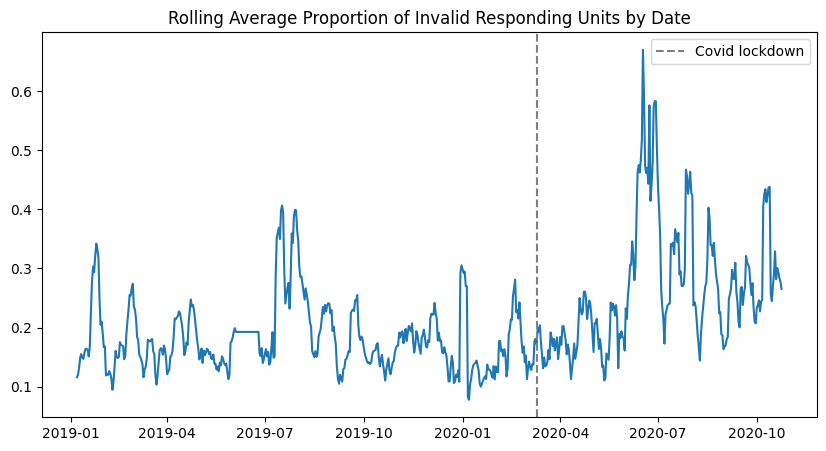

In [13]:
bad_count = df_bad.groupby("date").count().iloc[:,[0]].rename(columns = {"change_idx":"bad_count"}).reset_index()
good_count = df_good.groupby("date").count().iloc[:,[0]].rename(columns = {"change_idx":"good_count"}).reset_index()

both_count = bad_count.merge(good_count, right_on = "date", left_on = "date", how = "outer")
both_count.fillna(0, inplace = True)
both_count.sort_values(by = "date", inplace = True)
both_count["diff"] = (both_count["bad_count"] / both_count["good_count"]).rolling(window = 7).mean()

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(both_count["date"],both_count["diff"])
ax.set_title("Rolling Average Proportion of Invalid Responding Units by Date")
ax.axvline(x = covid, color = "grey", linestyle = "--", label = "Covid lockdown")
plt.legend()
plt.show()

In [14]:
df_bad["call_type"].value_counts()

Phone        1277
911           749
Other         713
Initiated     653
Walk-In       193
Radio          36
Name: call_type, dtype: int64

In [15]:
df_bad["call_category"].value_counts()

Administrative          1152
Nonemergency Service     788
Rapid Response           716
Initiated                653
Assist Other Agency      312
Name: call_category, dtype: int64

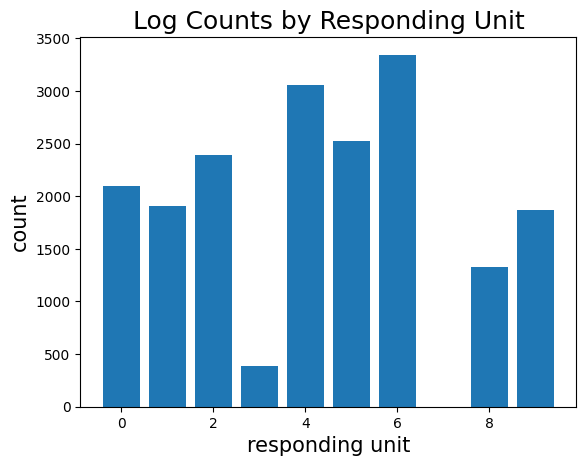

In [16]:
x = df["responding_units"].value_counts().index
y = df["responding_units"].value_counts().values

fig, ax = plt.subplots()
ax.bar(x,y)
ax.set_xlabel("responding unit", fontsize = 15)
ax.set_ylabel("count", fontsize = 15)

ax.set_title("Log Counts by Responding Unit", fontsize = 18)
plt.show()

Now we are ready to drop the calls and redefine our main dataframe, `df`.

In [17]:
df = df[~df["responding_units"].isna()].copy()
df.reset_index(drop = True, inplace = True)

print(f"{df.shape[0]} entries remaining.")
pre = df[df["date"] < covid].shape[0]
print(f"{pre} pre-covid entries remaining.")
print("")
print("Current Data Coverage: ")
df.count()/df.shape[0]*100

18916 entries remaining.
14686 pre-covid entries remaining.

Current Data Coverage: 


date                100.000000
change_idx          100.000000
log_num             100.000000
pdf_page            100.000000
call_datetime        94.480863
call_reason         100.000000
call_type           100.000000
call_action         100.000000
call_taker          100.000000
street              100.000000
call_category       100.000000
responding_units    100.000000
disp_datetime        95.612180
clrd_datetime        88.940579
dtype: float64

## Deal with missing `disp_datetime` and `clrd_datetime`

Next we will deal with missing dispatch datetimes and cleared datetimes.  

In [18]:
df_bad = df[(df["disp_datetime"].isna())|(df["clrd_datetime"].isna())]
df_good = df[(~df["disp_datetime"].isna())&(~df["clrd_datetime"].isna())]

In [19]:
pct_bad_pre = np.around(100 * df_bad[df_bad["date"] < covid].shape[0]/df[df["date"] < covid].shape[0], decimals = 2)
print(f"{pct_bad_pre}% of pre-covid entries are dropped.")

pct_bad_post = np.around(100 * df_bad[df_bad["date"] >= covid].shape[0]/df[df["date"] >= covid].shape[0], decimals = 2)
print(f"{pct_bad_post}% of post-covid entries are dropped.")

pct_bad = np.around(100 * df_bad.shape[0]/df.shape[0], decimals = 1)
print(f"{pct_bad}% of entries overall are dropped.")

16.7% of pre-covid entries are dropped.
6.52% of post-covid entries are dropped.
14.4% of entries overall are dropped.


Before we drop the values we want to make sure that there arent any meaniningful patterns in the distribution of dates, call types, and call categories.

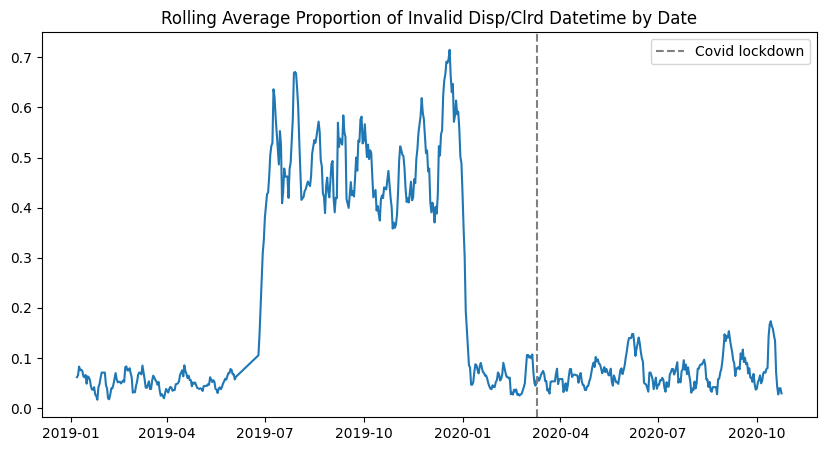

In [20]:
bad_count = df_bad.groupby("date").count().iloc[:,[0]].rename(columns = {"change_idx":"bad_count"}).reset_index()
good_count = df_good.groupby("date").count().iloc[:,[0]].rename(columns = {"change_idx":"good_count"}).reset_index()

both_count = bad_count.merge(good_count, right_on = "date", left_on = "date", how = "outer")
both_count.fillna(0, inplace = True)
both_count.sort_values(by = "date", inplace = True)
both_count["diff"] = (both_count["bad_count"] / both_count["good_count"]).rolling(window = 7).mean()

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(both_count["date"],both_count["diff"])
ax.set_title("Rolling Average Proportion of Invalid Disp/Clrd Datetime by Date")
ax.axvline(x = covid, color = "grey", linestyle = "--", label = "Covid lockdown")
plt.legend()
plt.show()

In [21]:
df_bad["call_type"].value_counts()

Initiated    1943
Phone         479
911           159
Other          90
Walk-In        43
Radio          15
Name: call_type, dtype: int64

In [22]:
df_bad["call_category"].value_counts()

Initiated               1943
Nonemergency Service     342
Rapid Response           323
Administrative            61
Assist Other Agency       60
Name: call_category, dtype: int64

Now we are ready to drop the calls and redefine our main dataframe, `df`.

In [23]:
df = df[(~df["disp_datetime"].isna())&(~df["clrd_datetime"].isna())].copy()
df.reset_index(drop = True, inplace = True)

print(f"{df.shape[0]} entries remaining.")
pre = df[df["date"] < covid].shape[0]
print(f"{pre} pre-covid entries remaining.")
print("")
print("Current Data Coverage: ")
df.count()/df.shape[0]*100

16187 entries remaining.
12233 pre-covid entries remaining.

Current Data Coverage: 


date                100.000000
change_idx          100.000000
log_num             100.000000
pdf_page            100.000000
call_datetime        98.887997
call_reason         100.000000
call_type           100.000000
call_action         100.000000
call_taker          100.000000
street              100.000000
call_category       100.000000
responding_units    100.000000
disp_datetime       100.000000
clrd_datetime       100.000000
dtype: float64

## Drop entries where `response_time` is illogical

First we will drop any entries where the time elapsed between `clrd_datetime` and `disp_datetime` is negative.

In [24]:
days = np.array([d.days for d in df["clrd_datetime"] - df["disp_datetime"]])
df_bad = df[days < 0]
df_good = df[days >= 0]

pct_bad_pre = np.around(100 * df_bad[df_bad["date"] < covid].shape[0]/df[df["date"] < covid].shape[0], decimals = 2)
print(f"{pct_bad_pre}% of pre-covid entries are dropped.")

pct_bad_post = np.around(100 * df_bad[df_bad["date"] >= covid].shape[0]/df[df["date"] >= covid].shape[0], decimals = 2)
print(f"{pct_bad_post}% of post-covid entries are dropped.")

pct_bad = np.around(100 * df_bad.shape[0]/df.shape[0], decimals = 1)
print(f"{pct_bad}% of entries overall are dropped.")

2.19% of pre-covid entries are dropped.
0.05% of post-covid entries are dropped.
1.7% of entries overall are dropped.


In [25]:
df = df[days >= 0].copy()
df.reset_index(drop = True, inplace = True)

print(f"{df.shape[0]} entries remaining.")
pre = df[df["date"] < covid].shape[0]
print(f"{pre} pre-covid entries remaining.")

15917 entries remaining.
11965 pre-covid entries remaining.


Next we drop any entries where the time elapsed between `disp_datetime` and `clrd_datetime` is greater than 120 minutes, since these occur very infrequently and can be considered as anomalous.

In [26]:
df["response_time_minutes"] = [d.seconds/60 for d in df["clrd_datetime"] - df["disp_datetime"]]
df_bad = df[df["response_time_minutes"] > 120]
df_good = df[df["response_time_minutes"] <= 120]

pct_bad_pre = np.around(100 * df_bad[df_bad["date"] < covid].shape[0]/df[df["date"] < covid].shape[0], decimals = 2)
print(f"{pct_bad_pre}% of pre-covid entries are dropped.")

pct_bad_post = np.around(100 * df_bad[df_bad["date"] >= covid].shape[0]/df[df["date"] >= covid].shape[0], decimals = 2)
print(f"{pct_bad_post}% of post-covid entries are dropped.")

pct_bad = np.around(100 * df_bad.shape[0]/df.shape[0], decimals = 1)
print(f"{pct_bad}% of entries overall are dropped.")

1.72% of pre-covid entries are dropped.
0.53% of post-covid entries are dropped.
1.4% of entries overall are dropped.


In [27]:
df = df[df["response_time_minutes"] <= 120].copy()
df.reset_index(drop = True, inplace = True)

print(f"{df.shape[0]} entries remaining.")
pre = df[df["date"] < covid].shape[0]
print(f"{pre} pre-covid entries remaining.")

15690 entries remaining.
11759 pre-covid entries remaining.


As a sanity check, let's inspect the mean response time.

In [28]:
mean_pre = np.around(df[df["date"] < covid]["response_time_minutes"].mean(), decimals = 2)
print(f"{mean_pre} minute mean response time for pre-covid calls.")

mean_post = np.around(df[df["date"] >= covid]["response_time_minutes"].mean(), decimals = 2)
print(f"{mean_post} minute mean response time for post-covid calls.")

mean_all = np.around(df["response_time_minutes"].mean(), decimals = 2)
print(f"{mean_all} minute mean response time for all calls.")

9.84 minute mean response time for pre-covid calls.
8.83 minute mean response time for post-covid calls.
9.59 minute mean response time for all calls.


In [29]:
df["log_response_time"] = np.log(df["response_time_minutes"] + 1e-08)
df["log_response_time"] = df["log_response_time"] - df["log_response_time"].min()

print("Current Data Coverage: ")
np.around(100 * df.count()/df.shape[0], decimals = 1)

Current Data Coverage: 


date                     100.0
change_idx               100.0
log_num                  100.0
pdf_page                 100.0
call_datetime             98.9
call_reason              100.0
call_type                100.0
call_action              100.0
call_taker               100.0
street                   100.0
call_category            100.0
responding_units         100.0
disp_datetime            100.0
clrd_datetime            100.0
response_time_minutes    100.0
log_response_time        100.0
dtype: float64

In [30]:
scaling_factor = np.log(df["response_time_minutes"] + 1e-08).min()

## Examine entries after Covid-19 lockdown

Since there were known to be widespread anomalies in policing as a consequence of the covid-19 lockdown on March 10, 2020, we will take a closer look at inconsistencies around this time.

In [31]:
print("Pre-covid call types:")
df_pre = df[df["date"] < covid]
print(df_pre["call_type"].value_counts()/df_pre.shape[0])
print("")
print("Post-covid call types:")
df_post = df[df["date"] >= covid]
print(df_post["call_type"].value_counts()/df_post.shape[0])

Pre-covid call types:
Initiated    0.765541
Phone        0.152479
911          0.047028
Walk-In      0.016583
Other        0.013351
Radio        0.005017
Name: call_type, dtype: float64

Post-covid call types:
Initiated    0.636734
Phone        0.237599
911          0.076571
Other        0.024421
Walk-In      0.019079
Radio        0.005597
Name: call_type, dtype: float64


In [32]:
df_month_pre = df[(df["date"] <= covid)&(df["date"] >= pd.to_datetime("2020-02-09"))]
df_month_post = df[(df["date"] >= covid)&(df["date"] <= pd.to_datetime("2020-04-09"))]

print(f"There were {df_month_pre.shape[0]} calls in the month prior to the lockdown")
print(f"There were {df_month_post.shape[0]} calls in the month prior to the lockdown")
print("")
print(f"The total call volume dropped by {np.around(100 * df_month_post.shape[0]/df_month_pre.shape[0], decimals = 2)}%")

There were 1066 calls in the month prior to the lockdown
There were 551 calls in the month prior to the lockdown

The total call volume dropped by 51.69%


In [33]:
#df = df[df["date"] < covid].copy()
analysis_2019 = df[df["date"] < pd.to_datetime("2020-01-01")].drop_duplicates("change_idx").shape[0]
analysis_2020 = df[df["date"] >= pd.to_datetime("2020-01-01")].drop_duplicates("change_idx").shape[0]
df_log_count.loc["analysis_log_count"] = [analysis_2019,analysis_2020]
df_log_count

,2019,2020
total_log_count,15973,10921
foia_log_count,15973,9100
ocr_log_count,12355,7535
pre_covid_log_count,12355,2674
analysis_log_count,8244,5728


## Add call datetime hour, weekday, and month

In [34]:
df["hour"] = np.array([d.hour for d in df["disp_datetime"]])
df["weekday"] = np.array([d.weekday() for d in df["disp_datetime"]])
df["month"] = np.array([d.month for d in df["disp_datetime"]])

## Analysis of preprocessing pipeline

In [35]:
df_preprocessing_stats = pd.DataFrame(columns = ["2019","2020"])
df_preprocessing_stats.loc["total_calls_analyzed"] = df_log_count.loc["analysis_log_count"].values
df_preprocessing_stats.loc["calls_dropped_for_quality_issues"] = (df_log_count.loc["ocr_log_count"] - df_log_count.loc["analysis_log_count"]).values
df_preprocessing_stats.loc["calls_not_read_by_OCR"] = (df_log_count.loc["foia_log_count"] - df_log_count.loc["ocr_log_count"]).values
df_preprocessing_stats.loc["calls_missing_from_records_request"] = (df_log_count.loc["total_log_count"] - df_log_count.loc["foia_log_count"]).values

print(df_preprocessing_stats.sum(axis = 0))

df_preprocessing_stats

2019    15973
2020    10921
dtype: int64


,2019,2020
total_calls_analyzed,8244,5728
calls_dropped_for_quality_issues,4111,1807
calls_not_read_by_OCR,3618,1565
calls_missing_from_records_request,0,1821


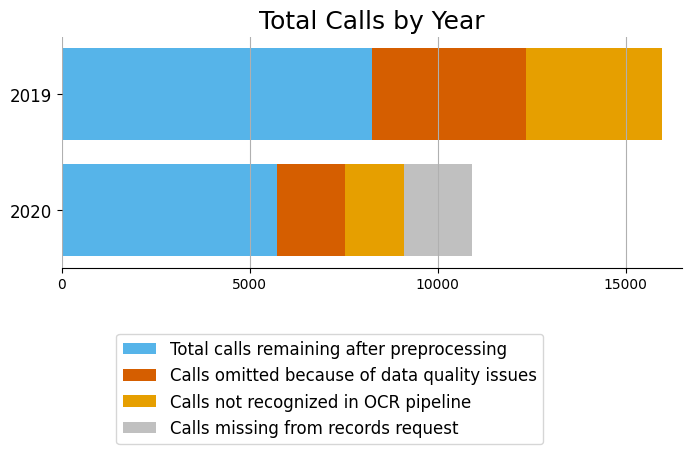

In [36]:
fig, ax = plt.subplots(figsize = (8,3))

width_total = df_preprocessing_stats.loc["total_calls_analyzed"].values
ax.barh(y = df_log_count.columns, width = width_total, label = "Total calls remaining after preprocessing", color = COLOR_MAP["light_blue"])

width_quality = df_preprocessing_stats.loc["calls_dropped_for_quality_issues"].values
left_quality = width_total
ax.barh(y = df_log_count.columns, width = width_quality, left = left_quality, label = "Calls omitted because of data quality issues", color = COLOR_MAP["dark_orange"])

width_ocr = df_preprocessing_stats.loc["calls_not_read_by_OCR"].values
left_ocr = width_quality + width_total
ax.barh(y = df_log_count.columns, width = width_ocr, left = left_ocr, label = "Calls not recognized in OCR pipeline", color = COLOR_MAP["light_orange"])

width_foia = df_preprocessing_stats.loc["calls_missing_from_records_request"].values
left_foia = width_quality + width_total + width_ocr 
ax.barh(y = df_log_count.columns, width = width_foia, left = left_foia, label = "Calls missing from records request", color = "silver")



ax.set_yticks([2019,2020])
ax.set_yticklabels([2019,2020],fontsize = 12)
ax.set_ylim(2020.5, 2018.5)

ax.set_xlim(0,16500)
ax.set_xticks([i * 5000 for i in range(4)],fontsize = 12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)

ax.xaxis.grid(True)

plt.legend(loc = "lower right", bbox_to_anchor = (.79,-.8), fontsize = 12)
plt.title("Total Calls by Year", fontsize = 18)
plt.show()

In [37]:
print("% total calls missing due to OCR pipeline or data quality issues")
df_preprocessing_stats.loc[["calls_not_read_by_OCR","calls_dropped_for_quality_issues"]].sum(axis = 0).sum()/df_preprocessing_stats.sum(axis = 0).sum()

% total calls missing due to OCR pipeline or data quality issues


0.41276864728192164

# 4. Exploratory Data Analysis

Among the `Initiated` calls, we'd like to know the top call reasons.  Recall that in cases where there are mutliple responding units, the same log entry appears multiple times in the dataframe.

In [38]:
df_unique = df.drop_duplicates("change_idx").copy()
reason_dict = df_unique[df_unique["call_type"] == "Initiated"]["call_reason"].value_counts().to_dict()

print(f"There are {len(reason_dict)} unique reasons for officer initated calls")
print("")
print(f"The top 5 reasons are: ")
count = 0
for i in range(5):
    reason = list(reason_dict.keys())[i]
    print(f"  {reason} - {reason_dict[reason]}")
    count += reason_dict[reason]
    
print("")
pct = np.around(100 * count / df_unique.shape[0], decimals = 2)
mean = np.around(df[df["call_type"] == "Initiated"]["response_time_minutes"].mean(), decimals = 2)
print(f"These account for {pct}% of all officer initiated calls with mean response time {mean} minutes.")

There are 23 unique reasons for officer initated calls

The top 5 reasons are: 
  BUILDING CHECK - 5220
  MOTOR VEHICLE STOP - 2194
  PARKING CHECK - 1719
  TRAFFIC CONTROL - 821
  SUSPICIOUS MOTOR VEHICLE - 221

These account for 73.34% of all officer initiated calls with mean response time 6.84 minutes.


Next we'll do the same analysis for non-`Initiated` calls, i.e. "calls for service".

In [39]:
df_unique = df.drop_duplicates("change_idx").copy()
reason_dict = df_unique[df_unique["call_type"] != "Initiated"]["call_reason"].value_counts().to_dict()

print(f"There are {len(reason_dict)} unique reasons for citizen calls for service")
print("")
print(f"The top 5 reasons are: ")
count = 0
for i in range(5):
    reason = list(reason_dict.keys())[i]
    print(f"  {reason} - {reason_dict[reason]}")
    count += reason_dict[reason]
    
print("")
pct = np.around(100 * count / df_unique.shape[0], decimals = 2)
mean = np.around(df[df["call_type"] != "Initiated"]["response_time_minutes"].mean(), decimals = 2)
print(f"These account for {pct}% of all citizen calls for service with mean response time {mean} minutes.")

There are 42 unique reasons for citizen calls for service

The top 5 reasons are: 
  MOTOR VEHICLE ACCIDENT - 277
  ANIMAL CONTROL - 268
  ALARM - 231
  SUSPICIOUS ACTIVITY - 224
  ASSIST OTHER AGENCY - 206

These account for 8.69% of all citizen calls for service with mean response time 17.14 minutes.


In [40]:
df["call_category"].value_counts()

Initiated               11505
Nonemergency Service     1821
Rapid Response           1736
Administrative            338
Assist Other Agency       290
Name: call_category, dtype: int64

In [41]:
df["call_type"].value_counts()

Initiated    11505
Phone         2727
911            854
Walk-In        270
Other          253
Radio           81
Name: call_type, dtype: int64

Mean Response Time Initiated: 6.84
Mean Response Time Service Call: 17.14


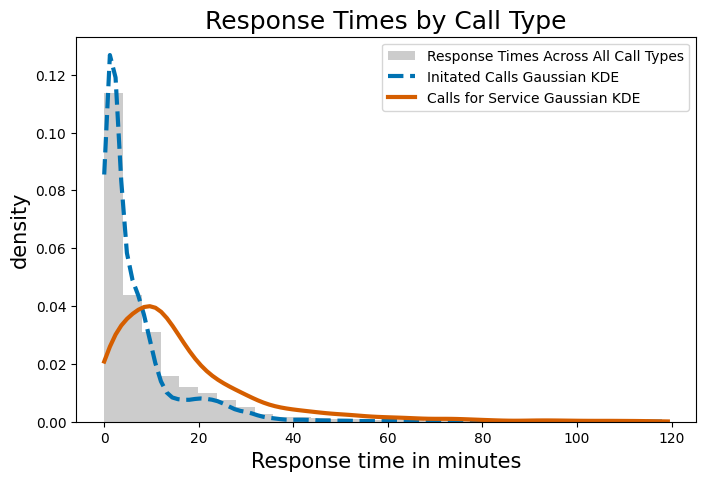

In [42]:
fig, ax = plt.subplots(figsize = (8,5))

y = df["response_time_minutes"]
ax.hist(y, bins = 30, density = True, color = "grey", alpha = .4,
       label = "Response Times Across All Call Types")

y = df[df["call_category"] == "Initiated"]["response_time_minutes"]
mrt = np.around(y.mean(), decimals = 2)
print(f"Mean Response Time Initiated: {mrt}")

kde = stats.gaussian_kde(y)
tt = np.linspace(y.min(), y.max(), 100)
ax.plot(tt, kde(tt), linewidth = 3, label = "Initated Calls Gaussian KDE", 
        color = COLOR_MAP["dark_blue"], linestyle = "--")

y = df[df["call_category"] != "Initiated"]["response_time_minutes"]
mrt = np.around(y.mean(), decimals = 2)
print(f"Mean Response Time Service Call: {mrt}")

kde = stats.gaussian_kde(y)
tt = np.linspace(y.min(), y.max(), 100)
ax.plot(tt, kde(tt), linewidth = 3, label = "Calls for Service Gaussian KDE", 
        color = COLOR_MAP["dark_orange"])

ax.set_xlabel("Response time in minutes", fontsize = 15)
ax.set_ylabel("density", fontsize = 15)


ax.set_title("Response Times by Call Type", fontsize = 18)
plt.legend()
plt.show()

## Keep only calls for service

In [43]:
df = df[df["call_category"] != "Initiated"].copy()
df.reset_index(drop = True, inplace = True)

df.head()

,date,change_idx,log_num,pdf_page,call_datetime,call_reason,call_type,call_action,call_taker,street,call_category,responding_units,disp_datetime,clrd_datetime,response_time_minutes,log_response_time,hour,weekday,month
0,2019-01-01,289,19-13,3,2019-01-01 11:22:00,ROAD CONDITIONS,911,REMOVED HAZARD,2.0,154.0,Rapid Response,4.0,2019-01-01 11:24:04,2019-01-01 11:31:31,7.450000,5.409411,11,1,1
1,2019-01-01,579,19-22a,4,2019-01-01 15:27:00,MOTOR VEHICLE ACCIDENT,911,BUILDING CHECKED/SECURED,11.0,171.0,Rapid Response,2.0,2019-01-01 15:27:00,2019-01-01 15:44:26,17.433333,6.259581,15,1,1
2,2019-01-01,579,19-22b,4,2019-01-01 15:27:00,MOTOR VEHICLE ACCIDENT,911,BUILDING CHECKED/SECURED,11.0,171.0,Rapid Response,9.0,2019-01-01 15:27:00,2019-01-01 15:46:09,19.150000,6.353500,15,1,1
3,2019-01-02,1370,19-42,6,2019-01-02 06:44:00,NOISE COMPLAINT,Phone,SERVICES RENDERED,6.0,107.0,Nonemergency Service,8.0,2019-01-02 06:47:25,2019-01-02 06:57:29,10.066667,5.710427,6,2,1
4,2019-01-02,1858,19-56,8,2019-01-02 10:00:00,PARKING CHECK,Phone,PATROL ADVISED,15.0,30.0,Nonemergency Service,4.0,2019-01-02 10:00:00,2019-01-02 10:01:04,1.066667,3.465736,10,2,1


# 6. Modeling 

## Data Transformation for Learning Pipeline

Fit time variables to cyclic splines, get one-hot for categorical and scale data.

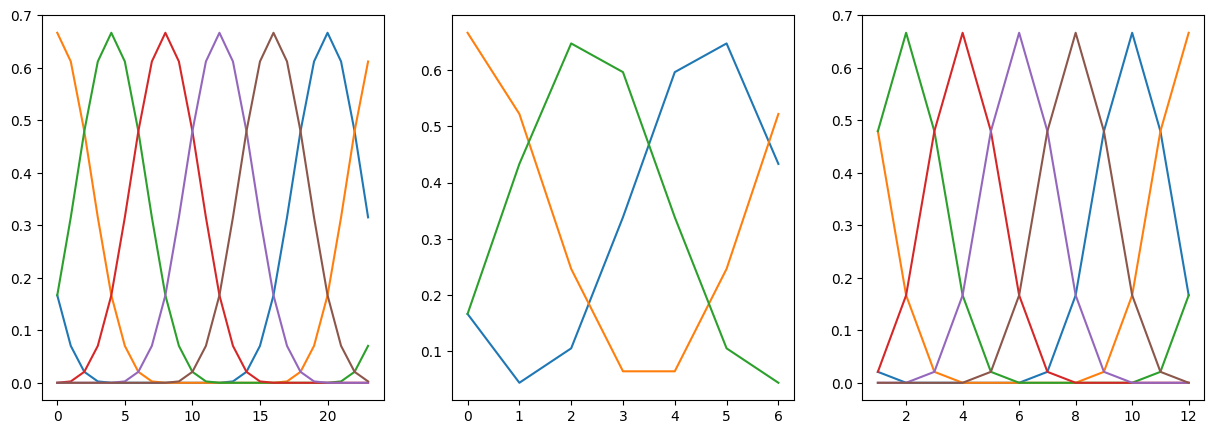

In [44]:
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import StandardScaler

def get_spline(degree, period, n_splines, df, feat):
    values = df[feat].values.reshape(-1,1)
    n_knots = n_splines + 1

    spline = SplineTransformer(degree=degree,
                             n_knots=n_knots, 
                             knots = np.linspace(0,period, n_knots).reshape(n_knots,1),
                             extrapolation = "periodic",
                             include_bias = True)
    spline_feat = spline.fit_transform(values)
    df_spline = pd.DataFrame(spline_feat, 
                             columns = [f"{feat}_cyclic_{i}" for i in range(spline_feat.shape[1])])
    
    return df_spline

fig, ax = plt.subplots(1,3, figsize = (15,5))

hr_spline = get_spline(degree = 3,
                       period = 24, 
                       n_splines = 6, 
                       df = df,
                       feat = "hour")

wk_spline = get_spline(degree = 3,
                       period = 7, 
                       n_splines = 3,
                       df = df,
                       feat = "weekday")

mo_spline = get_spline(degree = 3,
                       period = 12, 
                       n_splines = 6,
                       df = df,
                       feat = "month")

for i in range(hr_spline.shape[1]):
    idx = df["hour"].sort_values().index
    ax[0].plot(df["hour"].sort_values(),hr_spline.iloc[idx,i])
    
for i in range(wk_spline.shape[1]):
    idx = df["weekday"].sort_values().index
    ax[1].plot(df["weekday"].sort_values(),wk_spline.iloc[idx,i])
    
for i in range(mo_spline.shape[1]):
    idx = df["month"].sort_values().index
    ax[2].plot(df["month"].sort_values(),mo_spline.iloc[idx,i])
    


In [45]:
def prepare_data(df, categorical_feat, degree = 3, hr_splines = 12, wk_splines = 3, mo_splines = 6):
    
    # Get cyclic splines
    hr_spline = get_spline(degree = degree,
                       period = 24, 
                       n_splines = hr_splines, 
                       df = df,
                       feat = "hour")

    wk_spline = get_spline(degree = 3,
                           period = 7, 
                           n_splines = wk_splines,
                           df = df,
                           feat = "weekday")

    mo_spline = get_spline(degree = 3,
                           period = 12, 
                           n_splines = mo_splines,
                           df = df,
                           feat = "month")
    
    if len(categorical_feat) > 0:
        df[categorical_feat] = df[categorical_feat].astype(str)
        df_categorical = pd.get_dummies(df[categorical_feat])
    
        # Get one-hot categorical
        data = pd.concat([df_categorical,hr_spline, wk_spline, mo_spline], axis = 1)
    
    else:
        data = pd.concat([hr_spline, wk_spline, mo_spline], axis = 1)

    # Scale data
    scaler = StandardScaler().fit(data)
    X_scaled = scaler.transform(data)
    
    return X_scaled, df["log_response_time"], data

X_scaled, y, data = prepare_data(df, ["call_reason","call_taker","responding_units","call_category"])

print("Mean log response time: "+str(y.mean()))

Mean log response time: 5.732417601754409


## Poisson Regressor

In [46]:
from sklearn.model_selection import KFold
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model

def train_poisson_regressor(df, categorical_feat):
    
    X_scaled, y, data = prepare_data(df, categorical_feat)
    df_poisson_coef = pd.DataFrame(index = data.columns)
    df_poisson_score = pd.DataFrame()
    i = 0
    for _ in range(2):
        r = np.random.choice(100)
        kf = KFold(n_splits=10, shuffle = True, random_state = r)
        for train_index, test_index in kf.split(X_scaled):
            # Make train test split.
            X_train = X_scaled[train_index]
            y_train = y[train_index]

            X_test = X_scaled[test_index]
            y_test = y[test_index]

            # Fit model
            poisson_clf = linear_model.TweedieRegressor(power = 1, link = "identity", alpha = 1e-08).fit(X_train, y_train)
            
            # Add coeff to dataframe
            df_poisson_coef[i] = poisson_clf.coef_

            # Compute validation scores
            y_pred_train = poisson_clf.predict(X_train)
            y_pred_test = poisson_clf.predict(X_test)

            df_poisson_score.loc[i,"train_rmse"] = mean_squared_error(y_train, y_pred_train, squared=False)
            df_poisson_score.loc[i,"test_rmse"] = mean_squared_error(y_test, y_pred_test, squared=False)
            df_poisson_score.loc[i,"train_score"] = poisson_clf.score(X_train, y_train)
            df_poisson_score.loc[i,"test_score"] = poisson_clf.score(X_test, y_test)

            i += 1
        
    return df_poisson_score, df_poisson_coef

def print_stats(df_poisson_score):
    
    m_train = np.around(df_poisson_score["train_score"].mean(), decimals = 3)
    s_train = np.around(df_poisson_score["train_score"].std(), decimals = 3)
    
    m_test = np.around(df_poisson_score["test_score"].mean(), decimals = 3)
    s_test = np.around(df_poisson_score["test_score"].std(), decimals = 3)
    
    print(f"{m_train} $\pm$ {s_train} & {m_test} $\pm$ {s_test}\\")

In [47]:
df_poisson_score1, df_poisson_coef1 = train_poisson_regressor(df,[])
print_stats(df_poisson_score1)

0.029 $\pm$ 0.002 & 0.017 $\pm$ 0.016\


In [48]:
categorical_feat = ["call_category","responding_units"]
df_poisson_score2, df_poisson_coef2 = train_poisson_regressor(df,categorical_feat)
print_stats(df_poisson_score2)

0.064 $\pm$ 0.003 & 0.05 $\pm$ 0.024\


In [49]:
categorical_feat = ["call_category","responding_units","call_reason",]
df_poisson_score3, df_poisson_coef3 = train_poisson_regressor(df,categorical_feat)
print_stats(df_poisson_score3)

0.235 $\pm$ 0.005 & 0.206 $\pm$ 0.044\


In [50]:
categorical_feat = ["call_category","call_reason","responding_units","call_taker"]
df_poisson_score4, df_poisson_coef4 = train_poisson_regressor(df,categorical_feat)
print_stats(df_poisson_score4)

0.264 $\pm$ 0.006 & 0.229 $\pm$ 0.055\


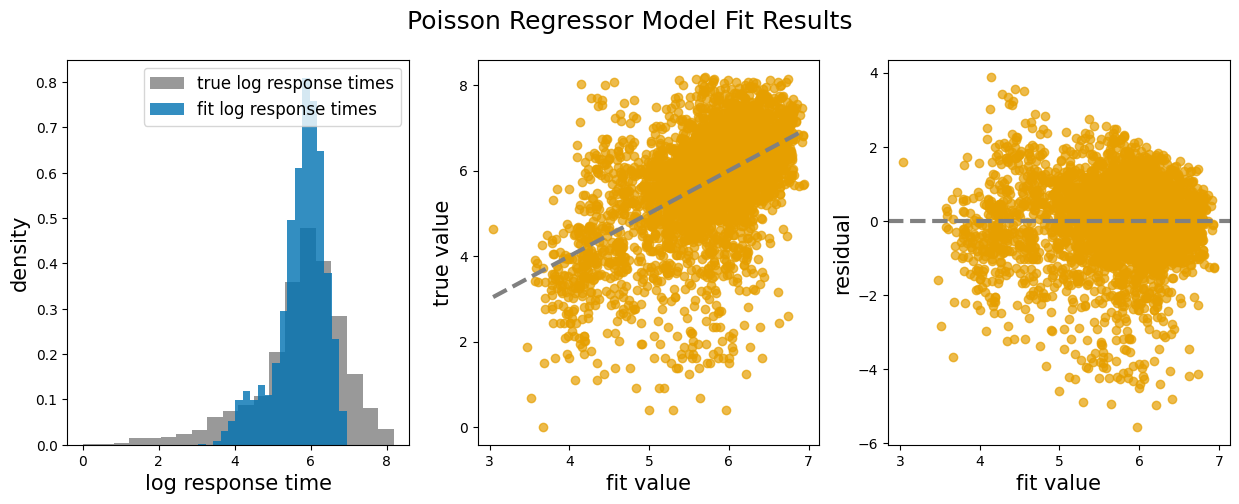

In [51]:
X_scaled, y, data = prepare_data(df, categorical_feat = ["call_category","call_reason","responding_units","call_taker"])
tweed_clf = linear_model.TweedieRegressor(power = 1, link = "identity", alpha = 1e-08).fit(X_scaled, y)

y_fit = tweed_clf.predict(X_scaled)

fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].hist(y, bins = 20, color = "grey", density = True, alpha = .8, label = "true log response times")
ax[0].hist(y_fit, bins = 20, color = COLOR_MAP["dark_blue"], density = True, alpha = .8, label = "fit log response times")
ax[0].set_xlabel("log response time", fontsize = 15)
ax[0].set_ylabel("density", fontsize = 15)
ax[0].legend(fontsize = 12)

ax[1].scatter(y_fit, y, color = COLOR_MAP["light_orange"], alpha = .7)
x = np.linspace(y_fit.min(), y_fit.max(), 100)
ax[1].plot(x,x, linestyle = "--", linewidth = 3, color = "grey")
ax[1].set_ylabel("true value", fontsize = 15)
ax[1].set_xlabel("fit value", fontsize = 15)

residual = (y - y_fit)
ax[2].scatter(y_fit, residual, color = COLOR_MAP["light_orange"], alpha = .7)
ax[2].axhline(0, linestyle = "--", linewidth = 3, color = "grey")
ax[2].set_xlabel("fit value", fontsize = 15)
ax[2].set_ylabel("residual", fontsize = 15)

plt.suptitle("Poisson Regressor Model Fit Results", fontsize = 18)
plt.show()

Plot Coefficients.

In [52]:
df_poisson_effect = np.exp(df_poisson_coef4) - 1
mean = df_poisson_effect.mean(axis = 1)
mean = mean.sort_values()

idx = [i for i in mean.index if not "_cyclic_" in i]

mean = mean.loc[idx]
std = df_poisson_effect.std(axis = 1).loc[idx]

rapid = mean.loc["call_category_Rapid Response"]

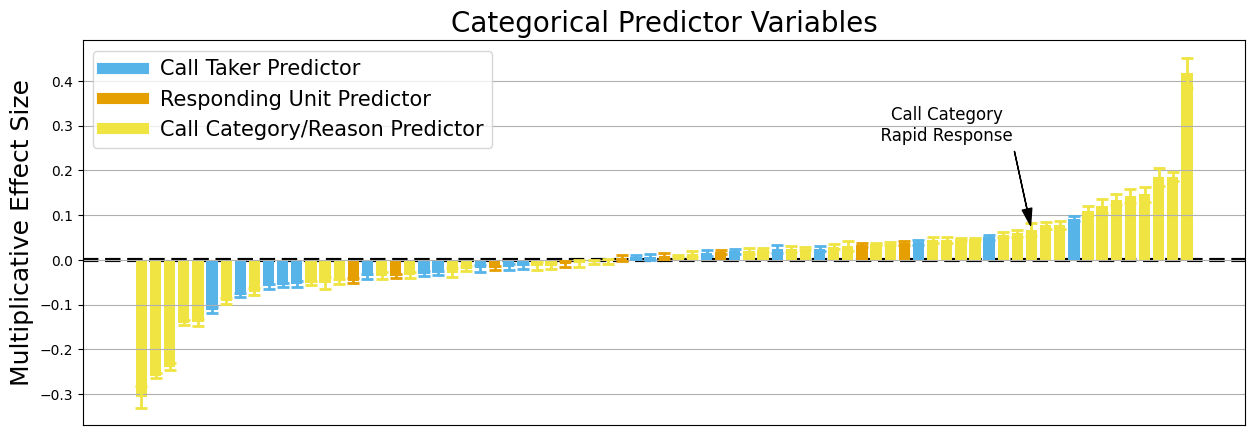

In [53]:
colors = []
for i in mean.index:
    if "call_taker" in i:
        colors.append(COLOR_MAP["light_blue"])
    elif "responding_units" in i:
        colors.append(COLOR_MAP["light_orange"])
    else:
        colors.append(COLOR_MAP["yellow"])

fig, ax = plt.subplots(figsize = (15,5))
ax.bar(mean.index, mean.values, color = colors, zorder = 1)
ax.axhline(y = 0, color = "k", linestyle = "--", zorder = 0, linewidth = 3)
for x, y, err, color in zip(mean.index, mean.values, std, colors):
    ax.errorbar(x = x, y = y, yerr = err, lw=2, capsize=4, capthick=2, color=color)

ax.set_xticks([])
ax.plot([],[], color = COLOR_MAP["light_blue"], linewidth = 8, label = "Call Taker Predictor")
ax.plot([],[], color = COLOR_MAP["light_orange"], linewidth = 8, label = "Responding Unit Predictor")
ax.plot([],[], color = COLOR_MAP["yellow"], linewidth = 8, label = "Call Category/Reason Predictor")


ax.annotate("Call Category  \n  Rapid Response", xy=('call_category_Rapid Response',rapid),  xycoords='data',
            xytext=(0.8, 0.83), textcoords='axes fraction',fontsize = 12,
            arrowprops=dict(facecolor='black', shrink=0.05, width = .1, headwidth = 7),
            horizontalalignment='right', verticalalignment='top')

ax.set_ylabel("Multiplicative Effect Size", fontsize = 18)
ax.yaxis.grid(True)

plt.title("Categorical Predictor Variables", fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

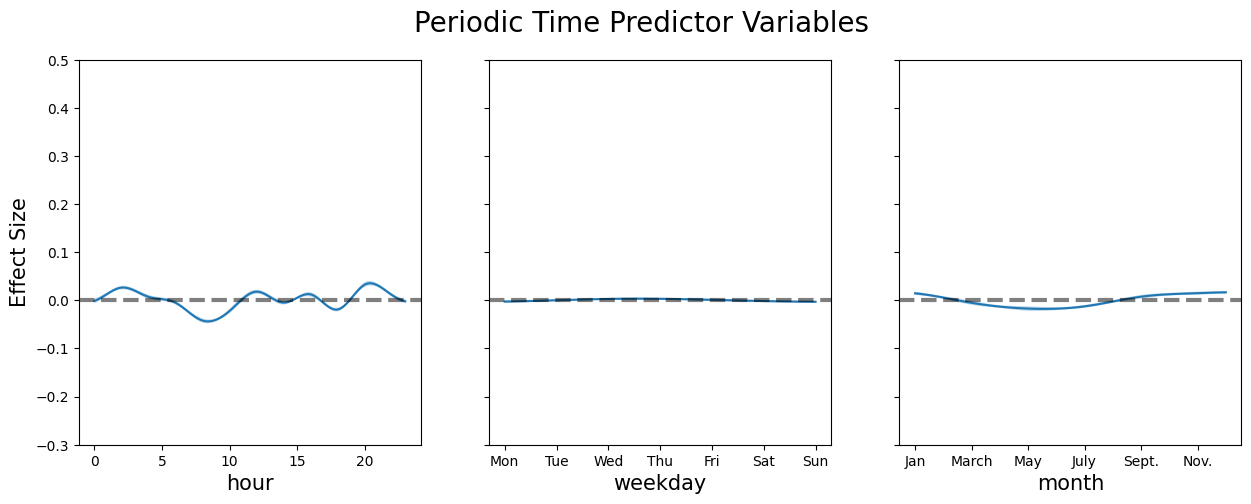

In [54]:
fig, ax = plt.subplots(1,3, figsize = (15,5), sharey = True)

# Week
hr_feat = [i for i in df_poisson_coef4.index if "hour" in i]
hr_space = pd.DataFrame(np.linspace(0,23,100), columns = ["hr_values"])
hr_spline = get_spline(degree = 3, period = 24, n_splines = 12, df = hr_space, feat = "hr_values")

df_poisson_effect = pd.DataFrame()

for i in range(df_poisson_coef4.shape[1]):
    glm = hr_spline.values * df_poisson_coef4.loc[hr_feat,i].values.reshape(1,-1)
    df_poisson_effect[i] = np.exp(glm.sum(axis = 1)) - 1

mean = df_poisson_effect.mean(axis = 1)
std = df_poisson_effect.std(axis = 1)

ax[0].plot(np.linspace(0,23,100), mean)
ax[0].fill_between(np.linspace(0,23,100), mean - std, mean + std, alpha = .3)
ax[0].set_ylabel("Effect Size", fontsize = 15)
ax[0].set_xlabel("hour", fontsize = 15)
ax[0].axhline(0, color = "k", linestyle = "--", alpha = .5, linewidth = 3)
ax[0].set_ylim(-0.3, 0.5)

# Week
wk_feat = [i for i in df_poisson_coef4.index if "week" in i]
wk_space = pd.DataFrame(np.linspace(0,6,100), columns = ["wk_values"])
wk_spline = get_spline(degree = 3, period = 7, n_splines = 3, df = wk_space, feat = "wk_values")

df_poisson_effect = pd.DataFrame()

for i in range(df_poisson_coef4.shape[1]):
    glm = wk_spline.values * df_poisson_coef4.loc[wk_feat,i].values.reshape(1,-1)
    df_poisson_effect[i] = np.exp(glm.sum(axis = 1)) - 1

mean = df_poisson_effect.mean(axis = 1)
std = df_poisson_effect.std(axis = 1)

ax[1].plot(np.linspace(0,6,100), mean)
ax[1].fill_between(np.linspace(0,6,100), mean - std, mean + std, alpha = .3)

ax[1].set_xticks([0,1,2,3,4,5,6])
ax[1].set_xticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax[1].set_xlabel("weekday", fontsize = 15)
ax[1].axhline(0, color = "k", linestyle = "--", alpha = .5, linewidth = 3)

# Month
mo_feat = [i for i in df_poisson_coef4.index if "month" in i]
mo_space = pd.DataFrame(np.linspace(0,11,100), columns = ["mo_values"])
mo_spline = get_spline(degree = 3, period = 12, n_splines = 6, df = mo_space, feat = "mo_values")

df_poisson_effect = pd.DataFrame()

for i in range(df_poisson_coef4.shape[1]):
    glm = mo_spline.values * df_poisson_coef4.loc[mo_feat,i].values.reshape(1,-1)
    df_poisson_effect[i] = np.exp(glm.sum(axis = 1)) - 1

mean = df_poisson_effect.mean(axis = 1)
std = df_poisson_effect.std(axis = 1)

ax[2].plot(np.linspace(0,11,100), mean)
ax[2].fill_between(np.linspace(0,11,100), mean - std, mean + std, alpha = .3)

ax[2].set_xticks([0,2,4,6,8,10])
ax[2].set_xticklabels(["Jan","March","May","July", "Sept.","Nov."])
ax[2].set_xlabel("month", fontsize = 15)
ax[2].axhline(0, color = "k", linestyle = "--", alpha = .5, linewidth = 3)

plt.suptitle("Periodic Time Predictor Variables", fontsize = 20)
plt.show()

In [55]:
m = np.around(df_poisson_score4["train_rmse"].mean(), decimals = 2)
s = np.around(df_poisson_score4["train_rmse"].std(), decimals = 2)

print(f"Train RMSE: {m} +/- {s}")

m = np.around(df_poisson_score4["test_rmse"].mean(), decimals = 2)
s = np.around(df_poisson_score4["test_rmse"].std(), decimals = 2)

print(f"Test RMSE: {m} +/- {s}")

Train RMSE: 1.01 +/- 0.01
Test RMSE: 1.03 +/- 0.07


In [56]:
m = np.around(df_poisson_score4["train_score"].mean(), decimals = 2)
s = np.around(df_poisson_score4["train_score"].std(), decimals = 2)

print(f"Train D^2: {m} +/- {s}")

m = np.around(df_poisson_score4["test_score"].mean(), decimals = 2)
s = np.around(df_poisson_score4["test_score"].std(), decimals = 2)

print(f"Test D^2: {m} +/- {s}")

Train D^2: 0.26 +/- 0.01
Test D^2: 0.23 +/- 0.06
